### Introduction
Our final project consist of four datasets, the 2019 regular season MLB pitching stats and hitting stats (This is our training data). We also bring in the current 2020 regular season MLB pitching and hitting stats (this is our testing data).

### About the data
- four dataset: 2019 MLB hitting and pitching, 2020 MLB hitting and pitching
- All datasets were pulled from [baseball-reference.com](https://www.baseball-reference.com/)

## Project Overview

In this project, we will build a model to predict weather or not a team has good pitchers or not based ERA, HR/9, WHIP. To accomplish this I will compare 3 classifier models:

- Logistical Regression
- Decision Tree
- Random Forest

Each model will be evaluated based on F1 score

#### Why use F1 score?

The F1 score enables us to take into account false negatives and false positives when calculating the accuracy of a model. If we use the generic accuracy_score method, false positives would be considered as correct predictions which is something that is inaccurate and would mislead me into thinking my model is more accurate than it is.



In [28]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [29]:
#Read-in 2019 Pitching Data
df = pd.read_csv('./mlb-pitching-2019.csv', index_col='Player')

df.head()

,Team,Age,G,GS,CG,SHO,IP,H,ER,K,BB,HR,W,L,SV,BS,HLD,ERA,WHIP
Player,,,,,,,,,,,,,,,,,,,
Justin Verlander,HOU,37,34,34,2,1,223.0,137,64,300,42,36,21,6,0,0,0,2.58,0.80
Shane Bieber,CLE,25,34,33,3,2,214.1,186,78,259,40,31,15,8,0,0,0,3.28,1.05
Gerrit Cole,HOU,29,33,33,0,0,212.1,142,59,326,48,29,20,5,0,0,0,2.50,0.89
Stephen Strasburg,WAS,32,33,33,0,0,209.0,161,77,251,56,24,18,6,0,0,0,3.32,1.04
Mike Minor,TEX,32,32,32,2,1,208.1,190,83,200,68,30,14,10,0,0,0,3.59,1.24


In [30]:
#Describe Data
df.describe()

,Age,G,GS,CG,SHO,IP,H,ER,K,BB,HR,W,L,SV,BS,HLD,ERA,WHIP
count,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,29.049312,24.470183,5.571101,0.051606,0.029817,49.449541,48.061927,24.824541,49.074541,18.172018,7.733945,2.785550,2.784404,1.352064,0.787844,2.815367,5.901456,1.568979
std,3.517527,19.554018,9.612563,0.280801,0.189339,49.913335,47.576281,23.209626,51.865699,16.011125,7.812989,3.696726,3.237884,5.039786,1.519015,5.455095,7.724401,1.072112
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,9.000000,0.000000,0.000000,0.000000,13.000000,14.000000,8.000000,11.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.647500,1.220000
50%,29.000000,20.000000,0.000000,0.000000,0.000000,33.100000,33.000000,17.000000,31.500000,13.500000,5.000000,1.000000,2.000000,0.000000,0.000000,0.000000,4.750000,1.410000
75%,31.000000,33.000000,7.000000,0.000000,0.000000,65.025000,62.000000,33.000000,69.250000,26.000000,10.000000,4.000000,4.000000,0.000000,1.000000,3.000000,6.390000,1.680000
max,43.000000,83.000000,34.000000,3.000000,2.000000,223.000000,225.000000,110.000000,326.000000,86.000000,39.000000,21.000000,17.000000,41.000000,9.000000,31.000000,162.000000,21.000000


In [31]:
#Get info on the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, Justin Verlander to Taylor Hearn
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Team    872 non-null    object 
 1   Age     872 non-null    int64  
 2   G       872 non-null    int64  
 3   GS      872 non-null    int64  
 4   CG      872 non-null    int64  
 5   SHO     872 non-null    int64  
 6   IP      872 non-null    float64
 7   H       872 non-null    int64  
 8   ER      872 non-null    int64  
 9   K       872 non-null    int64  
 10  BB      872 non-null    int64  
 11  HR      872 non-null    int64  
 12  W       872 non-null    int64  
 13  L       872 non-null    int64  
 14  SV      872 non-null    int64  
 15  BS      872 non-null    int64  
 16  HLD     872 non-null    int64  
 17  ERA     872 non-null    float64
 18  WHIP    872 non-null    float64
dtypes: float64(3), int64(15), object(1)
memory usage: 136.2+ KB


In [32]:
#Drop Team Column
df = df.drop(['Team'], axis=1)

In [33]:
#Get info on the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, Justin Verlander to Taylor Hearn
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     872 non-null    int64  
 1   G       872 non-null    int64  
 2   GS      872 non-null    int64  
 3   CG      872 non-null    int64  
 4   SHO     872 non-null    int64  
 5   IP      872 non-null    float64
 6   H       872 non-null    int64  
 7   ER      872 non-null    int64  
 8   K       872 non-null    int64  
 9   BB      872 non-null    int64  
 10  HR      872 non-null    int64  
 11  W       872 non-null    int64  
 12  L       872 non-null    int64  
 13  SV      872 non-null    int64  
 14  BS      872 non-null    int64  
 15  HLD     872 non-null    int64  
 16  ERA     872 non-null    float64
 17  WHIP    872 non-null    float64
dtypes: float64(3), int64(15)
memory usage: 129.4+ KB


#### I want to convert Tm to a category because I don't want to have to deal with objects later on in my model building

## I want to take a look at some distrobution plots on the dataset to know if we need to normalize any data.

In [34]:
# Correlation Matrix of quantitative features
c = df.corr()

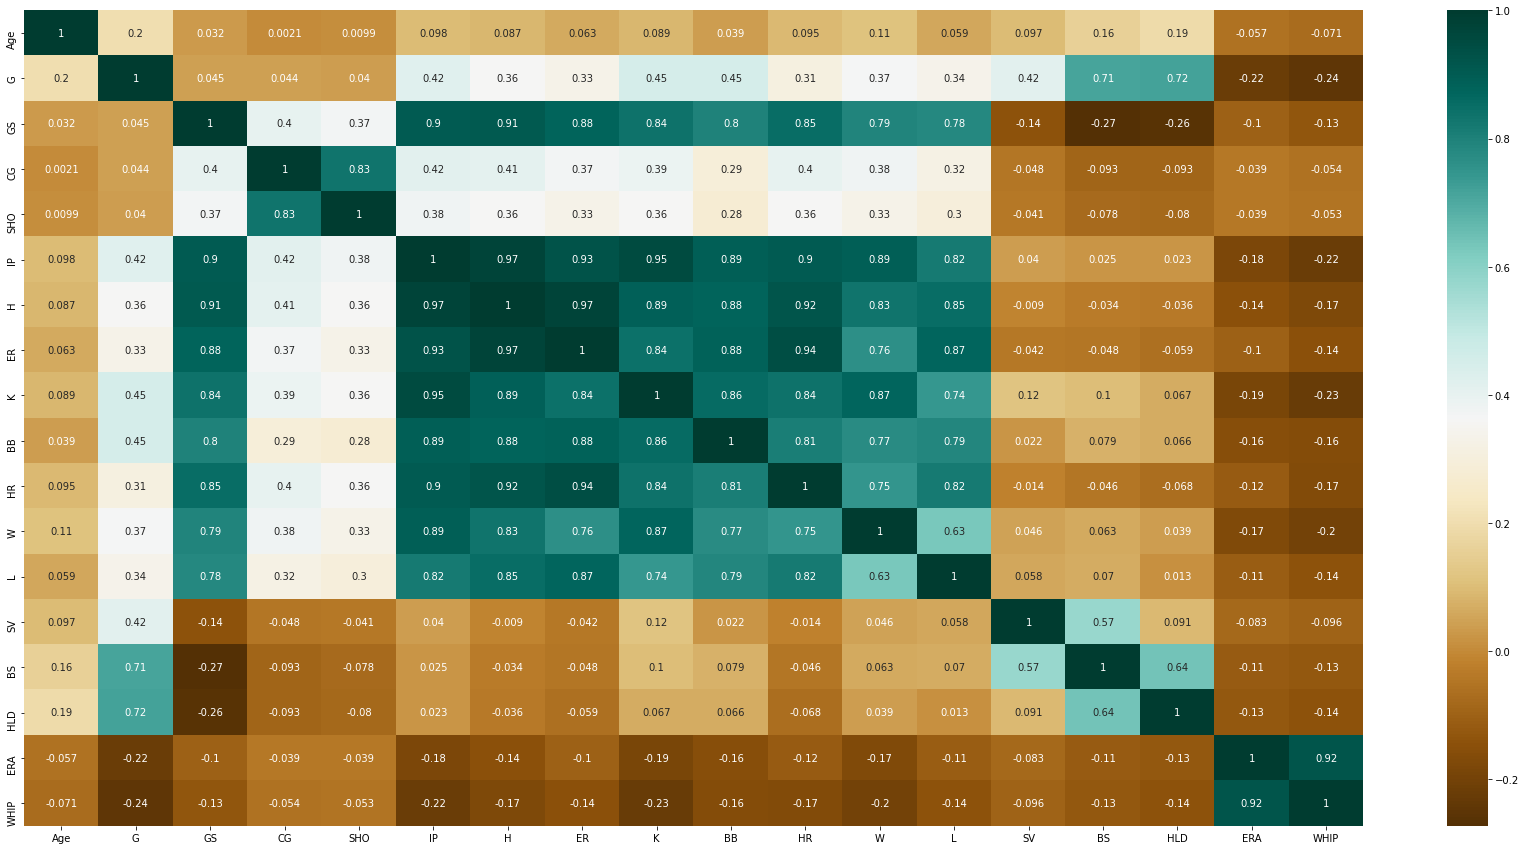

In [35]:
#visualizing the correlation matrix
plt.figure(figsize=(30,15))
sns.heatmap(c,cmap="BrBG", annot=True)

In [71]:
# Getting Features that have a correlation of greater than 0.5 for model building
selected_features = []
for i in range(len(c['W'])):
  if c['W'].values[i] >= 0.5 and c['W'].values[i] != 1.0:
    selected_features.append(c['W'].index[i])
  
selected_features

['GS', 'IP', 'H', 'ER', 'K', 'BB', 'HR', 'L']

In [72]:
#Required Imports
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor

In [73]:
X = df[selected_features]
y = df.W

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20)

In [75]:
# Logistical Regression Pipeline
lr = Pipeline(steps=[('LinReg', LinearRegression())])
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
r2_score(y_test, lr_preds)

0.8403393618789449

In [76]:
#Hyperparameter optimization for DecisionTreeRegressor
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline(steps=[('CV',GridSearchCV(DecisionTreeRegressor(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 15}

In [77]:
# DecisionTrees pipeline 
dt = Pipeline(steps=[('LogReg', DecisionTreeRegressor(max_depth=15))])
dt.fit(X_train,y_train)
dt_preds = dt.predict(X_test)
r2_score(y_test, dt_preds)

0.726958232971776

In [78]:
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
rfc = Pipeline([('CV',GridSearchCV(RandomForestRegressor(), parameters, cv = 5))])
rfc.fit(X_train, y_train)
rfc.named_steps['CV'].best_params_

{'max_depth': 6, 'n_estimators': 30}

In [79]:
# RandomForestTrees pipeline 
rf = Pipeline(steps=[('LogReg', RandomForestRegressor(max_depth=6,n_estimators=30))])
rf.fit(X_train,y_train)
rf_preds = rf.predict(X_test)
r2_score(y_test,rf_preds)

0.8456241690543361

# Lets make some predictions on the entire dataset with the LR model, which scored the best out of the 3 models we tested

In [80]:
y_pred = rf.predict(X)

In [81]:
predictions_df = pd.DataFrame({'Real W':df.W, 'Predicted W':y_pred})

In [82]:
predictions_df.head()

,Real W,Predicted W
Player,,
Justin Verlander,21,19.050000
Shane Bieber,15,13.901944
Gerrit Cole,20,17.913889
Stephen Strasburg,18,17.983333
Mike Minor,14,13.461956


In [83]:
# Exporting Model for later use
import pickle

filename = 'lr_pitching_model.sav'
pickle.dump(rf, open(filename, 'wb'))